# IMAGE CAPTIONING PROJECT

#### Import Modules

In [2]:
# CNN is used for Image Feature Extraction
# LSTM is used for Natural Langurage Processing
# os is for handling the files
# pickle is for storing some numpy features
# tqdm gives us a UI for how much data is processed till now, useful for getting an estimation of the overall process
# VGG16 is for extracting the features from image data 
# preprocess_input is for pre processing the image data for VGG16
# pad_sequences : It will even out the whole text representation of features, in order to fill out with 0s for the remaining length
# plot_model gives us a whole representation of the model in terms of an image

In [3]:
import os 
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding, add
from tqdm import tqdm

In [4]:
BASE_DIR = 'C:/Users/Pan18/Desktop/Projects/Image Captioning Project/flickr8k'
WORKING_DIR = 'C:/Users/Pan18/Desktop/Projects/Image Captioning Project/working'

#### Extract Image Features

In [5]:
# We don't need the fully connected layers of this VGG16 model we just need the previous layers to extract the feature results
# So, we are leaving the last layer and getting the previous layers output

In [6]:
# load the model
model = VGG16()
# restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# summarizing
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# We will create a dictionary where key will be the image id and value will be the features
# target_size : It is the width and height of the image that we will set

In [8]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from the file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # convert image pixels into numpy array
    image = img_to_array(image)
    # reshape the data for the model : format : (no_of_images, width, height, no_of_channels)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess the image for vgg
    image = preprocess_input(image)
    # extract features for image
    feature = model.predict(image, verbose = 0)
    # get image id
    img_id = img_name.split('.')[0] # we get the image id by splitting it on the basis of .jpeg
    # store features
    features[img_id] = feature

100%|██████████| 8091/8091 [52:52<00:00,  2.55it/s]  


In [9]:
# store features in pickle
# this will dump our dictionary into pickle and it will save us a lot of time

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [10]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

#### Load the Captions Data

In [11]:
# f.read() : It will read the whole text data
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 676145.36it/s]


In [13]:
len(mapping)

8091

#### Preprocessing the captions

In [14]:
# '\s+' is used for multiple spaces
# caption.replace([^A-Za-z], ' ') : it means except these characters, we are going to remove everything like digits and special
# characters.
# caption.replace('\s+', " ") : if we have multiple spaces, we will be using this command to remove additional spaces.
# if the length of the word is greater than 1 then we take that word for caption.

In [15]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces 
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'start ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption

In [16]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [19]:
# We will create a tokenizer to get the index of the corresponding word 
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
# we have around 5 captions for each image
len(all_captions)

40455

In [21]:
# first 10 captions
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

* Why we are using +1 in len(tokenizer.word_index) + 1 ?

Because Tokenizer.word_index is a python dictionary that contains token keys (string) and token ID values (integer), and where the first token ID is 1 (not zero) and where the token IDs are assigned incrementally. Therefore, the greatest token ID in word_index is len(word_index). Therefore, we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID.

In [22]:
# tokenize the text
# word_index is the total number of unique words that we are having
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

8311

In [24]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

#### Train Test Split

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split] # these are the images for the training data
test = image_ids[split:] # these are the images for the testing data2

In [26]:
# We will create a data generator in order to fetch the image and caption in batch size
# This encoding means for each word we will be assigning the index so we will be getting a list of 
# sequence index

Sequence Flow

In [27]:
# <start> girl going into wooden building <end>
#   X                           Y 
# <start>                       girl
# <start> girl                  going
# <start> girl going            into
# ............

# Initially we will be having the starting sequence so using this text sequence and the corresponding 
# image sequence we are going to predict the next word. And then we will concatenate both the input 
# and output to have it as the next input sequence 

# when we have the last prediction i.e. :
# <start> girl going into wooden building <end>
# we stop the prediction

In [28]:
# data_keys are the image_ids
# n is used to determine if we reach the batch size or not
# yield will return the collected samples to the generators 

* Yield is a keyword in Python that is used to return from a function without destroying the states of its local variable and when the function is called, the execution starts from the last yield statement.

In [29]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images 
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs 
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    # store the sequences 
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1,X2], y
                X1, X2, y = list(), list(), list()
                n = 0
                

#### Model Creation

In [30]:
# We will concantenate 2 features and plot the model

In [31]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


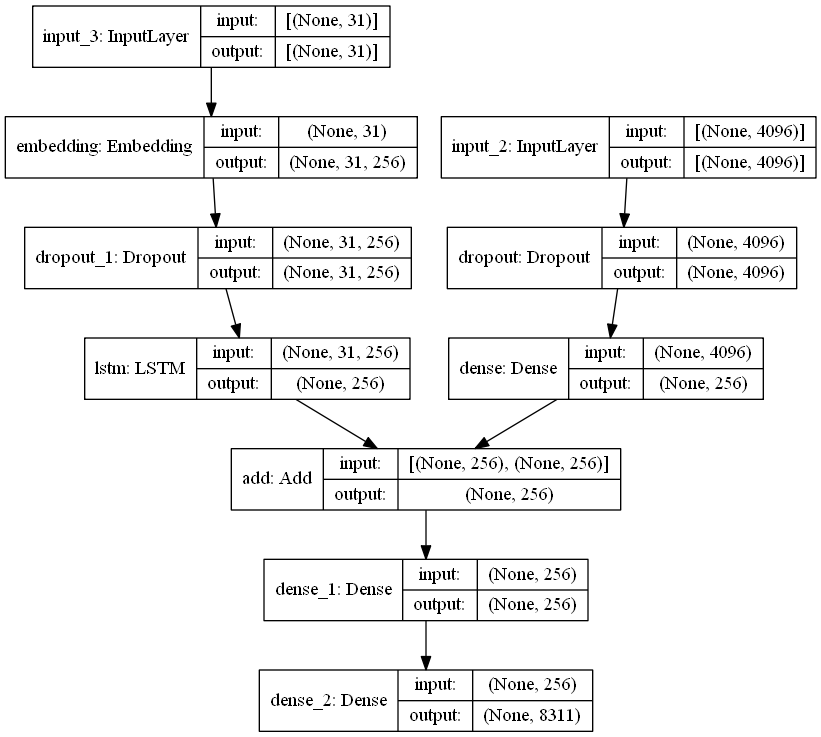

In [32]:
# encoder model
# image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
# sequence feature layers
inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1,inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# plot the model
plot_model(model, show_shapes = True)

In [33]:
# categorical one hot encoded output : 8483 classes, we are going to get the word with higher probability
# we have used CNN and LSTM concatination.

# We are going to get the word with higher probability as we have done categorical one hot encoding
# As we have extracted the features so we are not using CNN model to extract the image instead we are
# using VGG model
# If we don't use data generator then model will train quickly but it will take a lot of ram, but if 
# we use data generator then it will not require a lot of ram but it takes some time
# After each step it will do the back propagation and fetch the data 

In [34]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator 
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)

227/227 [==============================] - 526s 2s/step - loss: 2.1635


In [35]:
# save the model
model.save(WORKING_DIR + '/best_model.h5')

C:\Users\Pan18\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [36]:
# After training we need to create some functions for predicting the caption from the test images, also
# we will plot the image and the corresponding actual caption and predicted caption

#### Generate Captions for the Image

In [37]:
# We will convert the id into word i.e. index to word
# All the words we get from the model will be a index and we have to transform the index into word

In [38]:
# helper function
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [39]:
# for everything we want to predict we need to start with the start tag

In [40]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose = 0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word 
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
    
    return in_text

In [41]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data 
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights = (1.0,0,0,0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights = (0.5,0.5,0,0)))

100%|██████████| 810/810 [23:13<00:00,  1.72s/it]


BLEU-1: 0.521549
BLEU-2: 0.303348


#### Visualize the Results

In [42]:
pip install pillow

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1002674143_1b742ab4b8.jpg"
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print("------------------------Actual------------------------")
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("------------------------Predicted------------------------")
    print(y_pred)
    
    plt.imshow(image)

------------------------Actual------------------------
start little girl covered in paint sits in front of painted rainbow with her hands in bowl end
start little girl is sitting in front of large painted rainbow end
start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end
start there is girl with pigtails sitting in front of rainbow painting end
start young girl with pigtails painting outside in the grass end
------------------------Predicted------------------------
start little girl in red dress is climbing the sprinkler with fingerpaints end


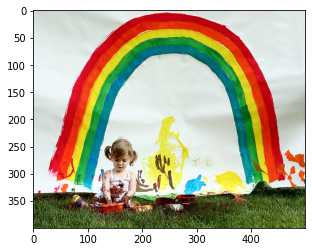

In [44]:
generate_caption("1002674143_1b742ab4b8.jpg")

------------------------Actual------------------------
start collage of one person climbing cliff end
start group of people are rock climbing on rock climbing wall end
start group of people climbing rock while one man belays end
start seven climbers are ascending rock face whilst another man stands holding the rope end
start several climbers in row are climbing the rock while the man in red watches and holds the line end
------------------------Predicted------------------------
start collage of rock climbers in front of rock wall end


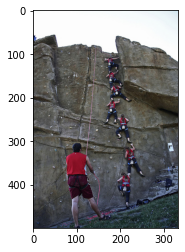

In [45]:
generate_caption('1016887272_03199f49c4.jpg')